## Import Packages

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
%matplotlib inline
import glob

In [42]:
#Options and Settings
warnings.simplefilter('ignore')
pd.options.display.max_columns = None
pd.options.display.max_rows = None
colors = sns.color_palette("Set3", 10)

In [43]:
#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

## Importing Datasets

Data Description
**client_data.csv**

- id = client company identifier
- activity_new = category of the company’s activity
- channel_sales = code of the sales channel
- cons_12m = electricity consumption of the past 12 months
- cons_gas_12m = gas consumption of the past 12 months
- cons_last_month = electricity consumption of the last month
- date_activ = date of activation of the contract
- date_end = registered date of the end of the contract
- date_modif_prod = date of the last modification of the product
- date_renewal = date of the next contract renewal
- forecast_cons_12m = forecasted electricity consumption for next 12 months
- forecast_cons_year = forecasted electricity consumption for the next calendar year
- forecast_discount_energy = forecasted value of current discount
- forecast_meter_rent_12m = forecasted bill of meter rental for the next 2 months
- forecast_price_energy_off_peak = forecasted energy price for 1st period (off peak)
- forecast_price_energy_peak = forecasted energy price for 2nd period (peak)
- forecast_price_pow_off_peak = forecasted power price for 1st period (off peak)
- has_gas = indicated if client is also a gas client
- imp_cons = current paid consumption
- margin_gross_pow_ele = gross margin on power subscription
- margin_net_pow_ele = net margin on power subscription
- nb_prod_act = number of active products and services
- net_margin = total net margin
- num_years_antig = antiquity of the client (in number of years)
- origin_up = code of the electricity campaign the customer first subscribed to
- pow_max = subscribed power
- churn = has the client churned over the next 3 months

**price_data.csv**

- id = client company identifier
- price_date = reference date
- price_off_peak_var = price of energy for the 1st period (off peak)
- price_peak_var = price of energy for the 2nd period (peak)
- price_mid_peak_var = price of energy for the 3rd period (mid peak)
- price_off_peak_fix = price of power for the 1st period (off peak)
- price_peak_fix = price of power for the 2nd period (peak)
- price_mid_peak_fix = price of power for the 3rd period (mid peak)


In [67]:
path = os.getcwd()
path = os.path.join(path,'dataset')

file_list = glob.glob(path+'/*csv')
names = [text.split("/")[-1].split(".")[0] for text in file_list]

for file,name in zip(file_list,names):
    df = pd.read_csv(file)
    globals()[f'{name}'] = df



## User Defined Functions

In [68]:
# Function to label partitions of pie chart

def annotation_labeling(lbl,vals):
    absolute = int(np.round(lbl/100.*np.sum(vals)))
    return "{:.1f}%\n({:d})".format(lbl,absolute)

In [69]:
def iqr_range(arr):
    q1 = np.quantile(arr, 0.25)
    q3 = np.quantile(arr,0.75)
    iqr = q3-q1
    return q1-(iqr*1.5),q3+(iqr*1.5)

In [70]:
def outlier_removal(df,column,drop_percentage=0.05):

    actual_rows = df.shape[0]
    lower_bound,upper_bound = iqr_range(df[column].values)
    outliers = df[ (df[column]<lower_bound) | (df[column] > upper_bound)]
    print('Total No of rows in actual dataframe: ',actual_rows,'\nTotal No of rows in outliers: ',outliers.shape[0])
    if outliers.shape[0] <= round(actual_rows*drop_percentage):
        df.drop(outliers.index,inplace=True)

    return df

## Exploring Price Data

In [71]:
price_data.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [72]:
price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  193002 non-null  object 
 1   price_date          193002 non-null  object 
 2   price_off_peak_var  193002 non-null  float64
 3   price_peak_var      193002 non-null  float64
 4   price_mid_peak_var  193002 non-null  float64
 5   price_off_peak_fix  193002 non-null  float64
 6   price_peak_fix      193002 non-null  float64
 7   price_mid_peak_fix  193002 non-null  float64
dtypes: float64(6), object(2)
memory usage: 11.8+ MB


In [73]:
#Checking for duplicates

price_data[price_data.duplicated()]

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix


In [74]:
price_data = price_data.astype({'price_date' : 'datetime64[ns]'})

In [75]:
print('No of unique clients: ', price_data.id.nunique())

price_data.describe()

No of unique clients:  16096


,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
count,193002,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000
mean,2015-06-16 12:50:49.933161216,0.141027,0.054630,0.030496,43.334477,10.622875,6.409984
min,2015-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-04-01 00:00:00,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000
50%,2015-07-01 00:00:00,0.146033,0.085483,0.000000,44.266930,0.000000,0.000000
75%,2015-10-01 00:00:00,0.151635,0.101673,0.072558,44.444710,24.339581,16.226389
max,2015-12-01 00:00:00,0.280700,0.229788,0.114102,59.444710,36.490692,17.458221
std,NaN,0.025032,0.049924,0.036298,5.410297,12.841895,7.773592


## Merging Client Dataset and Price Dataset
Merging price and client dataset using id

In [76]:
client_churn_info = client_data[['id','churn']]
price_df = client_churn_info.merge(price_data,on='id')

In [77]:
price_df.head()

,id,churn,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,24011ae4ebbe3035111d65fa7c15bc57,1,2015-01-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389
1,24011ae4ebbe3035111d65fa7c15bc57,1,2015-02-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389
2,24011ae4ebbe3035111d65fa7c15bc57,1,2015-03-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383
3,24011ae4ebbe3035111d65fa7c15bc57,1,2015-04-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383
4,24011ae4ebbe3035111d65fa7c15bc57,1,2015-05-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383


## Univariant Analysis
Plotting histogram to see the distribution of the data

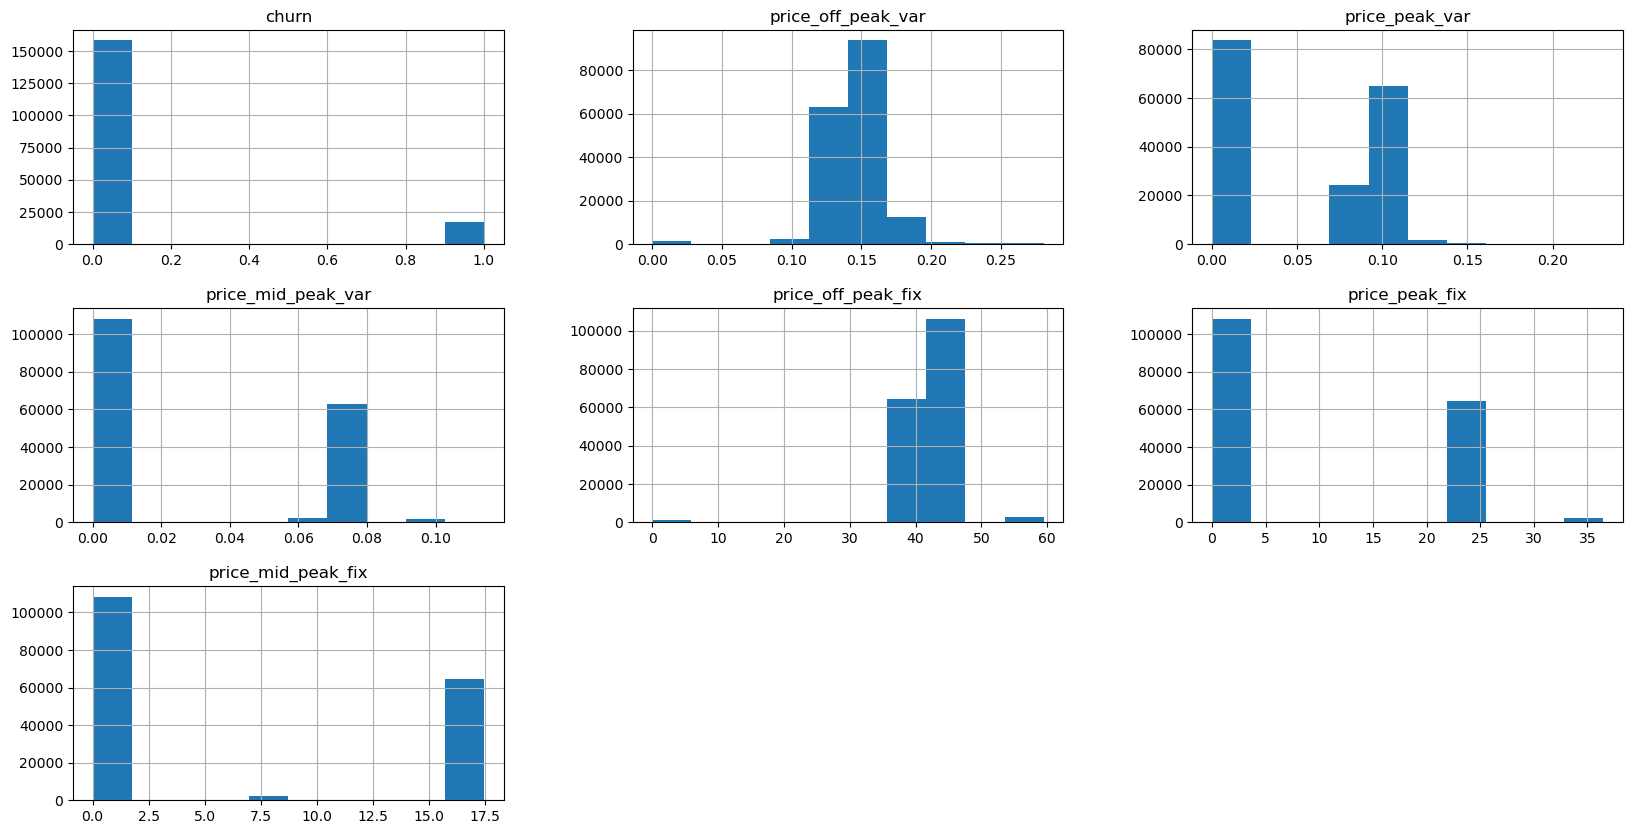

In [78]:
price_df.groupby(['id','price_date']).mean().hist(figsize=(20,10))
plt.show()

*The HistPlot shows that the data is skewed and show be treated before model creation*

## Plotting Energy and Power Prices

In [79]:
#Splitting the dataset into churn and non-churn price by price date

churn_grp_price = price_df[price_df['churn']==1].drop(columns=['id']).groupby(['price_date']).mean()
non_churn_grp_price = price_df[price_df['churn']==0].drop(columns=['id']).groupby(['price_date']).mean()

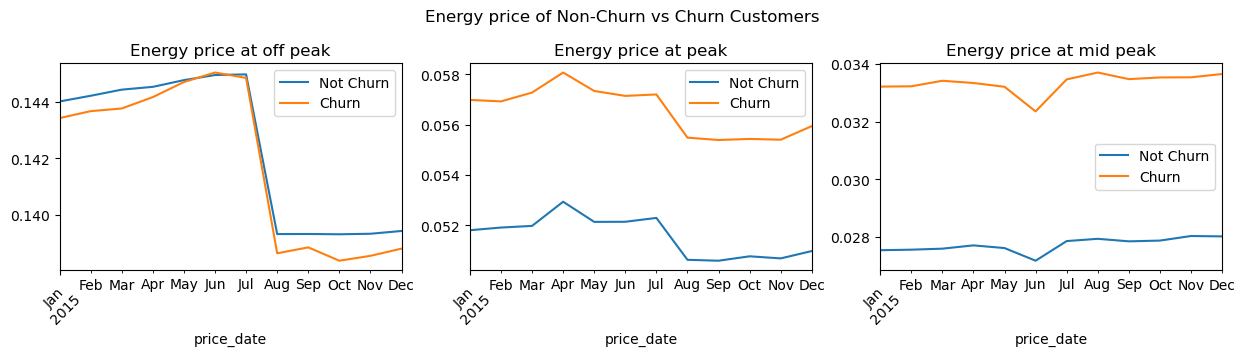

In [80]:
plt.figure(figsize=(15,3))
plt.axis('off')
plt.xticks(rotation=45)
plt.subplot(131)
non_churn_grp_price.price_off_peak_var.plot()
churn_grp_price.price_off_peak_var.plot()
plt.xticks(rotation=45)
plt.legend(['Not Churn','Churn'])
plt.title('Energy price at off peak')
plt.subplot(132)
non_churn_grp_price.price_peak_var.plot()
churn_grp_price.price_peak_var.plot()
plt.legend(['Not Churn','Churn'])
plt.title('Energy price at peak')
plt.xticks(rotation=45)
plt.subplot(133)
non_churn_grp_price.price_mid_peak_var.plot()
churn_grp_price.price_mid_peak_var.plot()
plt.legend(['Not Churn','Churn'])
plt.title('Energy price at mid peak')
plt.xticks(rotation=45)
plt.suptitle('Energy price of Non-Churn vs Churn Customers')
plt.subplots_adjust(top=0.8)
plt.show()

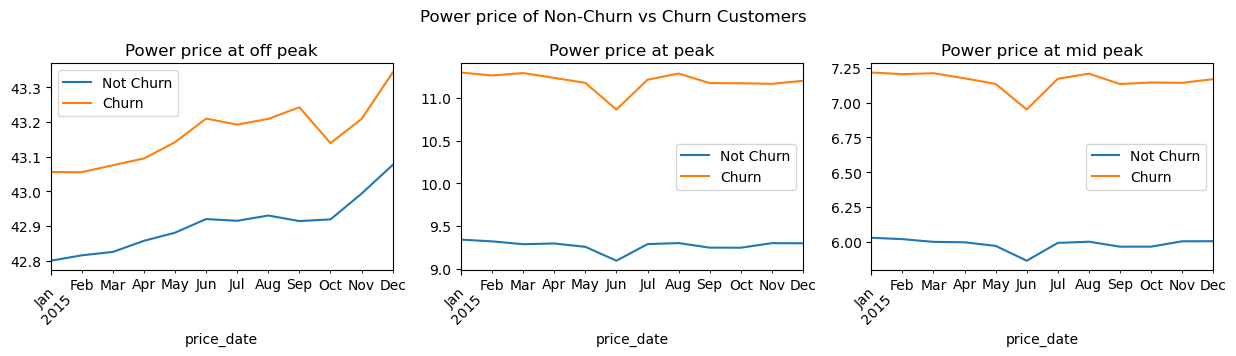

In [81]:
#Plotting average price of power by month
plt.figure(figsize=(15,3))
plt.axis('off')
plt.xticks(rotation=45)
plt.subplot(131)
non_churn_grp_price.price_off_peak_fix.plot()
churn_grp_price.price_off_peak_fix.plot()
plt.xticks(rotation=45)
plt.legend(['Not Churn','Churn'])
plt.title('Power price at off peak')
plt.subplot(132)
non_churn_grp_price.price_peak_fix.plot()
churn_grp_price.price_peak_fix.plot()
plt.legend(['Not Churn','Churn'])
plt.title('Power price at peak')
plt.xticks(rotation=45)
plt.subplot(133)
non_churn_grp_price.price_mid_peak_fix.plot()
churn_grp_price.price_mid_peak_fix.plot()
plt.legend(['Not Churn','Churn'])
plt.title('Power price at mid peak')
plt.xticks(rotation=45)
plt.suptitle('Power price of Non-Churn vs Churn Customers')
plt.subplots_adjust(top=0.8)
plt.show()


There is some variation of price between churn and un-churn clients. Churned clients have slightly low off-peak energy prices and high off-peak power prices. But we can't confidently say this is the factor for churn. We need to analyze the data further to arrive at a concrete conclusion.

## Correlational Heatmap
Before merging the dataset with the client dataset, we should conduct a correlation analysis to identify the features replicating the same information.

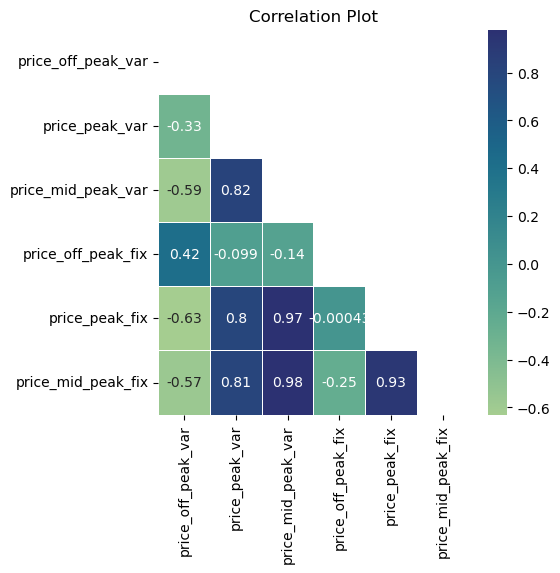

In [82]:
plt.figure(figsize=(5,5))
pd_corr = price_data.drop(columns=['id','price_date']).corr()
mask = np.triu(np.ones_like(pd_corr))
sns.heatmap(pd_corr,annot=True,cmap='crest',linewidths=.5,mask=mask)
plt.title('Correlation Plot')
plt.show()

In [83]:
price_data.drop(['price_peak_var','price_peak_fix','price_mid_peak_var'],axis=1,inplace=True)

High co-relation coefficient values between two features denote high dependency between them. It shows that the two features convey the same information. So one of the features can be dropped.

## Feature Engineering
Since the price information is monthly, we are unable to merge it directly with the client data. Some feature transformations need to be done to derive the yearly prices. The at peak and mid-peak of energy follow a linear flow, so we can take the average of the monthly prices. The eergy off peak price was high at the beginning of the year and low at the end of the year. So we take the price difference as a consolidated value.

In [84]:
#Filter out January and December energy off peak price
price_off_peak_energy = price_data[['id','price_off_peak_var']]
jan_prices = price_off_peak_energy.groupby('id').price_off_peak_var.first().reset_index().rename(columns={'price_off_peak_var':'price_off_peak_var_jan'})
dec_prices = price_off_peak_energy.groupby('id').price_off_peak_var.last().reset_index().rename(columns={'price_off_peak_var':'price_off_peak_var_dec'})

In [85]:
#Taking average of Power off-peak and mid-peak
price_data.drop('price_off_peak_var',axis=1,inplace=True)
price_data = price_data.groupby('id').mean().reset_index()

In [87]:
#Calculating Energy off peak difference
price_data = price_data.merge(jan_prices,on='id').merge(dec_prices,on='id')
price_data['energy_off_peak_variation'] = price_data.price_off_peak_var_jan - price_data.price_off_peak_var_dec
price_data.drop(['price_off_peak_var_jan','price_off_peak_var_dec'],axis=1,inplace=True)

In [88]:
price_data.head()

,id,price_date,price_off_peak_fix,price_mid_peak_fix,energy_off_peak_variation
0,0002203ffbb812588b632b9e628cc38d,2015-06-16 12:00:00,40.701732,16.280694,0.006192
1,0004351ebdd665e6ee664792efc4fd13,2015-06-16 12:00:00,44.385450,0.000000,0.004104
2,0010bcc39e42b3c2131ed2ce55246e3c,2015-06-16 12:00:00,45.319710,0.000000,-0.050443
3,0010ee3855fdea87602a5b7aba8e42de,2015-06-16 12:00:00,40.647427,16.258971,0.010018
4,00114d74e963e47177db89bc70108537,2015-06-16 12:00:00,44.266930,0.000000,0.003994


## Exploring Client Data

In [89]:
client_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0


In [90]:
client_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

In [92]:
#Checking for duplicates
client_data[client_data.duplicated()]

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn


In [93]:
client_data = client_data.astype({
    'date_activ' : 'datetime64[ns]',
    'date_end' : 'datetime64[ns]',
    'date_modif_prod' : 'datetime64[ns]',
    'date_renewal' : 'datetime64[ns]'
})

### Data Cleaning and Feature Engineering

In [95]:
#Changing hashed values to meaningful labels for easy understanding
print('Unique Sales Channels :\n',client_data.channel_sales.unique())
print('\nUnique Origin :\n',client_data.origin_up.unique())

Unique Sales Channels :
 ['foosdfpfkusacimwkcsosbicdxkicaua' 'MISSING'
 'lmkebamcaaclubfxadlmueccxoimlema' 'usilxuppasemubllopkaafesmlibmsdf'
 'ewpakwlliwisiwduibdlfmalxowmwpci' 'epumfxlbckeskwekxbiuasklxalciiuu'
 'sddiedcslfslkckwlfkdpoeeailfpeds' 'fixdbufsefwooaasfcxdxadsiekoceaa']

Unique Origin :
 ['lxidpiddsbxsbosboudacockeimpuepw' 'kamkkxfxxuwbdslkwifmmcsiusiuosws'
 'ldkssxwpmemidmecebumciepifcamkci' 'MISSING'
 'usapbepcfoloekilkwsdiboslwaxobdp' 'ewxeelcelemmiwuafmddpobolfuxioce']


In [96]:
channel_mask = {
    'MISSING':'missing_data',
    'foosdfpfkusacimwkcsosbicdxkicaua':'channel_1',
    'lmkebamcaaclubfxadlmueccxoimlema':'channel_2',
    'usilxuppasemubllopkaafesmlibmsdf':'channel_3',
    'ewpakwlliwisiwduibdlfmalxowmwpci':'channel_4',
    'epumfxlbckeskwekxbiuasklxalciiuu':'channel_5',
    'sddiedcslfslkckwlfkdpoeeailfpeds':'channel_6',
    'fixdbufsefwooaasfcxdxadsiekoceaa':'channel_7',
}
origin_mask = {
    'lxidpiddsbxsbosboudacockeimpuepw' : 'origin_1',
    'kamkkxfxxuwbdslkwifmmcsiusiuosws' : 'origin_2',
    'ldkssxwpmemidmecebumciepifcamkci' : 'origin_3',
    'usapbepcfoloekilkwsdiboslwaxobdp' : 'origin_4',
    'ewxeelcelemmiwuafmddpobolfuxioce' : 'origin_5',
    'MISSING' : 'origin_missing'
}
client_data.replace({
    'has_gas' : {
        't':1,'f':0
    },
    'channel_sales':channel_mask,
    'origin_up':origin_mask,
},inplace=True)
#Labeled Data
client_data.head()


,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,channel_1,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,1,0.00,25.44,25.44,2,678.99,3,origin_1,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,missing_data,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,0,0.00,16.38,16.38,1,18.89,6,origin_2,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,channel_1,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,0,0.00,28.60,28.60,1,6.60,6,origin_2,13.856,0
3,bba03439a292a1e166f80264c16191cb,channel_2,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,0,0.00,30.22,30.22,1,25.46,6,origin_2,13.200,0
4,149d57cf92fc41cf94415803a877cb4b,missing_data,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,0,52.32,44.91,44.91,1,47.98,6,origin_2,19.800,0


In [97]:
#contract_modification_interval : no of years in which the client last modified their contract.
#contract_interval : no of years client travelled with us.
client_data['contract_modification_interval'] = client_data.date_modif_prod.dt.year - client_data.date_activ.dt.year
client_data['contract_interval'] = client_data.date_end.dt.year - client_data.date_activ.dt.year